## Stacking Method
In this kernel, I will do different feature engineering and fit several models and fine tune them. Then I will stacking method, i.e. feeding the output from the models as input to another model. The baseline model used here are RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, SVC, CatBoost. And the end, I will feed the outputs into XGBoostClassifier and fit a final model.

In [284]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import re
import pickle
from os import path
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [285]:
# feature analysis and feature engineering
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
y = df_train.dropna(subset=['Embarked']).Survived
full_set = [df_train, df_test]
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [220]:
age_median = np.median(df_train.Age)
age_quantile = df_train.Age.quantile(np.arange(0.2,1,0.2))
fare_quantile = df_train.Fare.quantile(np.arange(0.2,1,0.2))
# define function for first stage feature engineering
def quantile_category(feature, quant):
    
    ' put featuer into categories'
    
    init = 0.2
    category = 1
    while init < 1:
        if feature <= quant[init]:
            return category
        init += 0.2
        category += 1
        
    return category

def cabin_class(row):
    
    'map cabin to a categorical number'
    
    cabin_to_num = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    
    if row['Cabin'] is np.NaN or row['Cabin'][0] not in cabin_to_num:
        return 8
    
    return cabin_to_num[row['Cabin'][0]]

def embark(row):
    
    'map embark port to categorical number'
    
    embark_to_num = {'S':1, 'C':2, 'Q':3}
    
    if row.Embarked not in embark_to_num:
        return 0
    
    return embark_to_num[row.Embarked]

def get_title(name):
    
    ' this function extract title from the Name string '
    
    title = re.search(' ([A-Za-z]+)\.', name).group(1)
    common_used = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4}
    # fancy French title in English
    title_convert = {'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'}
    
    if title in title_convert:
        title = title_convert[title]
    
    if title not in common_used:
        title = 0
    else:
        title = common_used[title]
        
    return title

def feature_engineering(dataset):
    # create new feature cabin_category to indicate which class of cabin the passenger is in
    dataset['cabin_category'] = dataset.apply(cabin_class, axis=1)
    
    # create new feature family_size to indicate the passenger is travelling with how many family members
    dataset['family_size'] = dataset.SibSp + dataset.Parch + 1
    
    # create new feature is_alone to indicate whether the passenger is traveling alone
    dataset['is_alone'] = dataset.family_size.apply(lambda x: 1 if x == 1 else 0)
    
    # map sex from string to int
    dataset['gender'] = dataset.apply(lambda x: 1 if x.Sex == 'male' else 0, axis=1)
    
    # replace the missing values in age by median
    dataset.loc[dataset.Age.isnull(), 'Age'] = age_median
    
    # extract title for each passenger and turn them into numerical category
    dataset['title'] = dataset.Name.apply(get_title)
    
    # create new feature embark to indicate from which location the passenger boards Titanic
    dataset = dataset.dropna(subset=['Embarked']).reset_index()
    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(dataset.Embarked.values.reshape(-1,1))
    col = ohe.categories_
    temp = pd.DataFrame(columns=col, data=X_ohe)
    dataset_ = pd.concat([dataset, temp], axis=1)
    
    # convert Age, Fare into categories
    dataset_['age_cat'] = dataset.Age.apply(quantile_category, quant=age_quantile)
    dataset_['fare_cat'] = dataset.Fare.apply(quantile_category, quant=fare_quantile)
        
    return dataset_
        

In [221]:
x = feature_engineering(df_train)
colum_drop = ['PassengerId', 'Survived', 'Name', 'Sex', 'SibSp', 'Ticket', 'Cabin', 'Embarked', 'Age']
x = x.drop(colum_drop, axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 14 columns):
index             889 non-null int64
Pclass            889 non-null int64
Parch             889 non-null int64
Fare              889 non-null float64
cabin_category    889 non-null int64
family_size       889 non-null int64
is_alone          889 non-null int64
gender            889 non-null int64
title             889 non-null int64
(C,)              889 non-null float64
(Q,)              889 non-null float64
(S,)              889 non-null float64
age_cat           889 non-null int64
fare_cat          889 non-null int64
dtypes: float64(4), int64(10)
memory usage: 97.4 KB


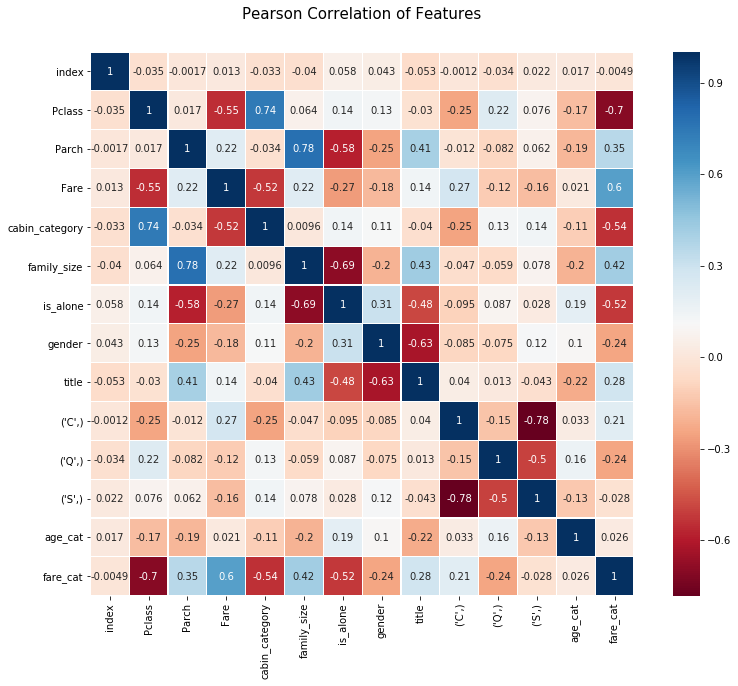

In [222]:
# plot heatmap
colormap = plt.cm.RdBu
plt.figure(figsize=(14,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(x.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [237]:
# implement several classifier and select best hyperparameters using grid search cross validation
param_grid = {RandomForestClassifier:
                 {
                    'n_estimators': (40,70,100,200, 500), 
                    'max_depth': (3,4,5,6,7),
                    'min_samples_leaf': (2,3,4),
                 },
             AdaBoostClassifier:
                 {
                    'n_estimators': (70, 100, 150, 200, 500),
                    'learning_rate' : (0.05, 0.1, 0.25, 0.5)
                 },
             GradientBoostingClassifier:
                 {
                    'n_estimators': (70, 100, 150, 200, 500),
                    'max_depth': (3,4,5,6,7),
                    'min_samples_leaf': (2,3,4),
                 },
             SVC:
                 {
                    'kernel' : ('linear', 'rbf'),
                    'C' : (0.025, 0.05, 0.1)
                 }}

class GridSearchHelper(object):
    def __init__(self, clf, clf_params, param_grid, x, y, cv):
        self.clf_base = clf(**clf_params)
        self.param_grid = param_grid
        self.x = x
        self.y = y
        self.cv = cv
        
    def fit(self):
        grid_clf = GridSearchCV(self.clf_base, self.param_grid, cv=self.cv)
        grid_clf.fit(self.x, self.y)
        return grid_clf
    
    def get_result(self):
        clf = self.fit()
        result = pd.DataFrame(clf.cv_results_).sort_values(['mean_test_score', 'std_test_score'], \
                                                           ascending=[False, True])
        return result, clf.best_estimator_

param = {'random_state':0}
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clfs = [RandomForestClassifier, 
        AdaBoostClassifier, 
        GradientBoostingClassifier, 
        SVC]

best_clf = []
cv_result = []

for clf, grid in param_grid.items():
    if path.exists('models.sav'):
        with open('models.sav', 'rb') as f:
            best_clf = pickle.load(f)
        break
    gs = GridSearchHelper(clf, param, grid, x, y, cv)
    result, best = gs.get_result()
    cv_result.append(result)
    best_clf.append(best)


In [238]:
# save the best models into a file
filename = 'models.sav'
with open (filename, "wb") as f:
    pickle.dump(best_clf, f)

In [274]:
# create an array to combine the prediction from classifiers

def baseline_output(clfs, x):
    
    ' calculate the baseline models output to a matrix '
    
    initialize = True
    for clf in best_clf:
        prediction = clf.predict(x).reshape((-1,1))

        if initialize:
            arr = prediction
            initialize = False
            continue

        arr = np.hstack((arr, prediction))
    
    return arr

arr = baseline_output(best_clf, x)

In [270]:
# feed the matrix into XGBoostClassifier and fine tune
param_grid = {
     'n_estimators': (40, 70,100, 200, 300),
     'learning_rate': (0.025, 0.05, 0.1),
     'max_depth': (2,3,4,5),
     'min_child_weight': (2,3,4),
     'gamma': (0, 0.5, 0.9, 1.2),                        
     'subsample': (0.5,0.8, 1),
     'colsample_bytree': (0.5, 0.8, 0.1),
}

if not path.exists('final_xgb.sav'):
    gs_xgb = GridSearchHelper(XGBClassifier, param, param_grid, arr, y, cv)
    result, best_xgb = gs_xgb.get_result()
    with open('final_xgb.sav', 'wb') as f:
        pickle.dump(best_xgb, f)
else:
    with open('final_xgb.sav', 'rb') as f:
        final_xgb = pickle.load(f)
        

In [269]:
# store the final XGBClassifier to file
final_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.5, gamma=0,
               learning_rate=0.05, max_delta_step=0, max_depth=2,
               min_child_weight=2, missing=None, n_estimators=300, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)
filename_xgb = 'final_xgb.sav'
with open(filename_xgb, 'wb') as f:
    pickle.dump(final_xgb, f)

In [309]:
df_test_ = pd.read_csv('data/test.csv')
df_test = feature_engineering(df_test_)
df_test.loc[df_test.Fare.isnull(), 'Fare'] = np.median(x.Fare)
colum_drop = ['PassengerId', 'Name', 'Sex', 'SibSp', 'Ticket', 'Cabin', 'Embarked', 'Age']
df_test = df_test.drop(colum_drop, axis=1)

In [312]:
# predict on test set
final_xgb.fit(arr, y)
xgb_input = baseline_output(best_clf, df_test)
output_xgb = final_xgb.predict(xgb_input)
submission_df = pd.DataFrame({'PassengerId': df_test_.PassengerId, 'Survived': output_xgb})
submission_df.to_csv('stacking_result.csv', index=False)